[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/EMforGaussianMixture.ipynb)

# Expectation Maximization for Gaussian Mixture Model
In K-means each datapoint is assigned to one cluster. An alternative is for each datapoint ($n$) to have a distribution over clusters -- that is $r_{n,k} \in [0,1]$ and $\sum_k r_{n,k} = 1$. To do this we can assume each cluster has a Gaussian distribution $\mathcal{N}(\mu_k, \Sigma_k)$. So we assume the data-distrubtion is a **mixture of Gaussians**
$$
p(x; \pi, \{\mu_k, \Sigma_k\}) = \sum_k \pi_k \mathcal{N}(x; \mu_k, \Sigma_k)
$$
where $\pi_k= p(z=k)$ with $\sum_k \pi_k = 1$ defining the weight of each Gaussian in the mixture. These weights should sum to one so that we have a valid pdf. To maximize the logarithm of the marginal-likelihood 
$\ell(\pi, \{\mu_k, \Sigma_k\}) = \sum_n \log \left ( \sum_k \pi_k \mathcal{N}(x; \mu_k, \Sigma_k) \right)$, we set its partial derivative wrt various parameters to zero. This gives us the value of these parameters in terms of membership probabilities, aka *responsibilities*: $r_{n,k} = p(z=k|x^{(n)})= \frac{\pi_k \mathcal{N}(x; \mu_k, \Sigma_k)}{\sum_c \pi_c \mathcal{N}(x; \mu_c, \Sigma_c)}$. Since responsibilities are functions of model parmeters, we perform an iterative updating of these two values:
1. update responsibilites given the model parameters 
2. given the responsibilities $r_{n,k}$, update the parameters $\mu_k, \Sigma_k$ and $\pi$. As we said these updates are given by taking the derivative of the log-likelihood:
    - New $\pi_k$ is easy to estimate, it is proportional to the $\sum_n r_{n,k}$. Since $\pi_k$ should sum to one we set
$$
\pi_k = \frac{\sum_n r_{n,k}}{\sum_{n,c} r_{n,c}}
$$
    - For $\mu_k$ and $\Sigma_k$ we need to estimate mean and covariance of a Gaussian using *weighted* samples, where the (unnormalized) weights for the $k^{th}$ Gaussian in the mixture are $r_{n,k} \forall n$.
\begin{align}
\mu_k &= \frac{\sum_n r_{n,k} x^{(n)}}{\sum_n r_{n,k}} \\
\Sigma_k &= \frac{ \sum_n r_{n,k} (x^{(n)} - \mu_k)(x^{(n)} - \mu_k)^\top }{\sum_n r_{n,k}}
\end{align}
The above gives us weighted mean and weighted covariance. We then repeat steps 1 and 2 similar to K-means.

Lets implement EM for Gaussian Mixture Model (GMM) below. We re-use our previous impelementation of multivariate Gaussian in GMM.

In [12]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import scipy as sp
np.random.seed(1234)

In [13]:
#For more comments on multivariate Gaussian class refer to: https://github.com/mravanba/comp551-notebooks/blob/master/Gaussian.ipynb
class Gaussian():
    def __init__(self, mu=0, sigma=0):
        self.mu = np.atleast_1d(mu)
        if np.array(sigma).ndim == 0:
            self.Sigma = np.atleast_2d(sigma**2)
        else:
            self.Sigma = sigma

    def density(self, x):
        N,D = x.shape
        xm = (x-self.mu[None,:])
        normalization = (2*np.pi)**(-D/2) * np.linalg.det(self.Sigma)**(-1/2)
        quadratic = np.sum((xm @ np.linalg.inv(self.Sigma)) * xm, 1)
        return normalization * np.exp(-.5 * quadratic)


class GMM:
    def __init__(self, K=5, max_iters=200, epsilon=1e-5):
        self.K = K                            #Number of Gaussians
        self.max_iters = max_iters            #maximum number of iteration we want to run the mixture model
        self.epsilon = epsilon                #small value used as tolerance and for alleviating the singularity problem
    
    def fit(self, x):
        N,D = x.shape
        init_centers = np.random.choice(N, self.K)                               #generate K random values from [0,N-1]
        pi = np.ones(self.K)/self.K                                              #initialize the weight of the Gaussians
        mu = x[init_centers]                                                     #select K data points to initialize the mean parameter of K Gaussians
        sigma = np.tile(np.diag(np.var(x,axis=0))[None,:,:], (self.K, 1,1))      #initialize the sigma parameter by computing the variance of the data and making a diagonal matrix from it
        #Note that the tile function copies the sigma K times for all the Gausssians 
        r = np.zeros((N,self.K))                                                 #initialize the responsibilities to zero
        ll = -np.inf                                                             #initialize the log likelihood to negative inifinity
        for t in range(self.max_iters):
            #update the responsibilities
            for i in range(self.K):
                r[:,i] = pi[i] * Gaussian(mu[i], sigma[i]).density(x)            
            #normalize them over number of Gaussians 
            r_norm = r / np.sum(r, axis=1, keepdims=True)                        #keepdims preserves the 2nd dimension for broadcasting during the division
            #update the parameters of the gaussian using MLE
            for i in range(self.K):
                mu[i,:] = np.average(x, axis=0, weights=r_norm[:,i])             #computes the weighted average where the weights are given by responsibilities of the i-th Gaussian
                sigma[i,:,:] = np.cov(x, aweights=r_norm[:,i], rowvar=False) + self.epsilon * np.eye(D)[None,:,:]
                #Note that we compute the weighted covariance natrix where the weights are given by responsibilities of the i-th Gaussian
                #We set rowvar False as our data is in the first axis with the feature variables in the second and we want to compute variance along columns
                #An epsilon variance is added in all the features to make sure it doesn't reach singularity where a Gaussian fit a single data point with zero variance in all the features 
            #update the weight of Gaussians
            pi = np.sum(r_norm, 0)
            pi /= np.sum(pi)                                                     #normalize it
            #calculate the new log likelihood
            ll_new = np.mean(np.log(np.sum(r,axis=1)))
            #check if the log likelihood differenc is within the tolerance
            if np.abs(ll_new - ll) < self.epsilon:
                print(f'converged after {t} iterations, average log-likelihood {ll_new}')
                break
            ll = ll_new
        return mu, sigma, r

In the implementation above note that we add a diagonal matrix with small constant values ($\epsilon$) on the diagonal to the empirical covariance matrix. This is to avoid degeneracy. If the model puts one of the Gaussians centered on a data-points and make the covariance very small, it can arbitrarily increase the likelihood of the data (see Bishop p.434). This addition of epsilon to the diagonal prevents this degeneracy.

Now let's apply this to the Iris dataset 

converged after 56 iterations, average log-likelihood -1.4838900349678374


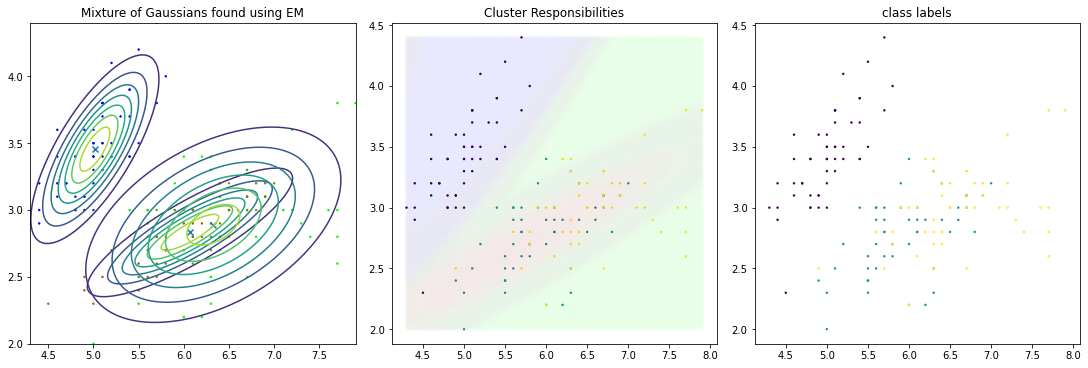

In [16]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,:2], dataset['target']

gmm = GMM(K=3)
mu, sigma, resp = gmm.fit(x)
resp /= np.sum(resp,axis=1,keepdims=True)

# plotting the result
fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5))
axes[0].scatter(x[:,0], x[:,1], c=resp, s=2)
axes[0].scatter(mu[:,0], mu[:,1], marker='x')

x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

#Get the densities 
p0 = Gaussian(mu[0], sigma[0]).density(x_all)
p1 = Gaussian(mu[1], sigma[1]).density(x_all)
p2 = Gaussian(mu[2], sigma[2]).density(x_all)
p = np.vstack([p0,p1,p2]).T
p /= np.sum(p,axis=1,keepdims=True)

#axes[0].contour(x0, x1, p0.reshape(x0.shape)) 
axes[0].tricontour(x_all[:,0], x_all[:,1], p0)
axes[0].tricontour(x_all[:,0], x_all[:,1], p1)
axes[0].tricontour(x_all[:,0], x_all[:,1], p2)
axes[0].set_title('Mixture of Gaussians found using EM')

axes[1].scatter(x[:,0], x[:,1], c=y, s=2)
axes[1].scatter(x_all[:,0], x_all[:,1], c=p, marker='.', alpha=.01)
axes[1].set_title('Cluster Responsibilities')

axes[2].scatter(x[:,0], x[:,1], c=y, s=2)
axes[2].set_title('class labels')
plt.show()

A mixture of Gaussians where the membership of each point is unobserved is an example of a **latent variable model**.
A latent variable model $p(x,z; \theta)$ assumes unobserved or latent variables $z$ that help explain the observations $x$. In this setup we still want to maximize the **marginal likelihood** of data ($z$ is marginalized out):
$$
\max_\theta \sum_n \log p(x^{(n)}; \theta) = \max_\theta \sum_n \log \sum_z p(x^{(n)}, z; \theta)
$$
EM can be used for learning with *latent variable models* or when we have *missing data*. The general approach is similar to what we saw here: 
- computing the posterior $p(z | x^{(n)}; \theta) \forall n$ (Expectation or **E step**)
- maximizing the expected log-likelihood using this probabilistic *completion* of the data (Maximization or **M step**)